In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==2.10.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


2024-12-21 14:50:12.006828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-21 14:50:12.151922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-21 14:50:12.151968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-21 14:50:12.185891: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 14:50:12.924767: W tensorflow/stream_executor/platform/de

119/119 [==============================] - 2s 8ms/step - loss: 1.1779 - accuracy: 0.4933 - val_loss: 0.8317 - val_accuracy: 0.6524
Epoch 2/350
119/119 [==============================] - 1s 7ms/step - loss: 0.8632 - accuracy: 0.6115 - val_loss: 0.7706 - val_accuracy: 0.6560
Epoch 3/350
119/119 [==============================] - 1s 7ms/step - loss: 0.8118 - accuracy: 0.6458 - val_loss: 0.7493 - val_accuracy: 0.6310
Epoch 4/350
119/119 [==============================] - 1s 7ms/step - loss: 0.7890 - accuracy: 0.6540 - val_loss: 0.7175 - val_accuracy: 0.6988
Epoch 5/350
119/119 [==============================] - 1s 7ms/step - loss: 0.7569 - accuracy: 0.6676 - val_loss: 0.6882 - val_accuracy: 0.6952
Epoch 6/350
119/119 [==============================] - 1s 7ms/step - loss: 0.7421 - accuracy: 0.6783 - 

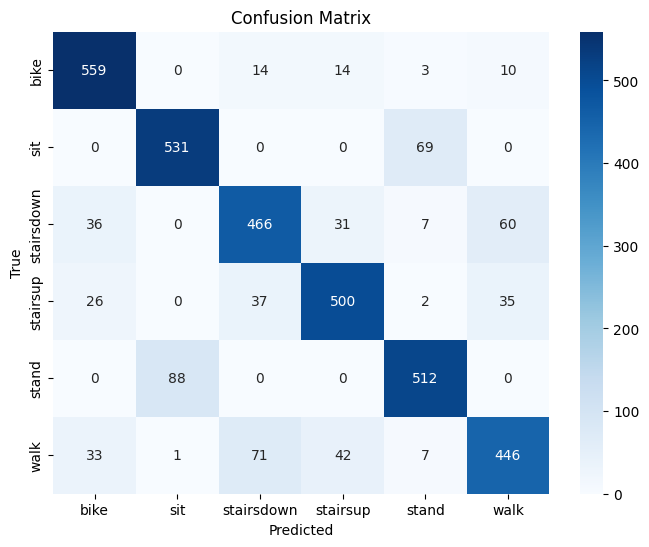

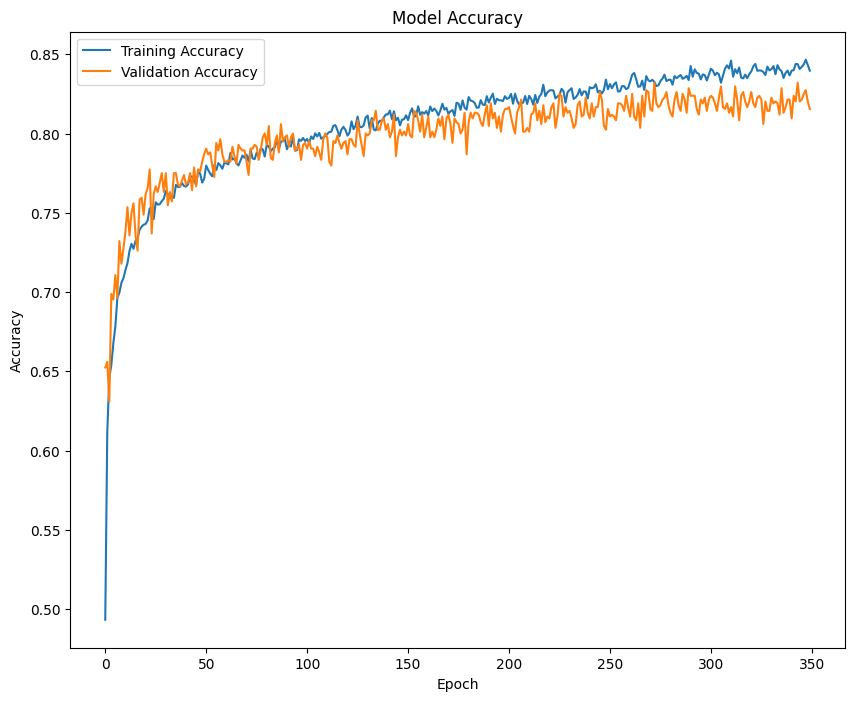

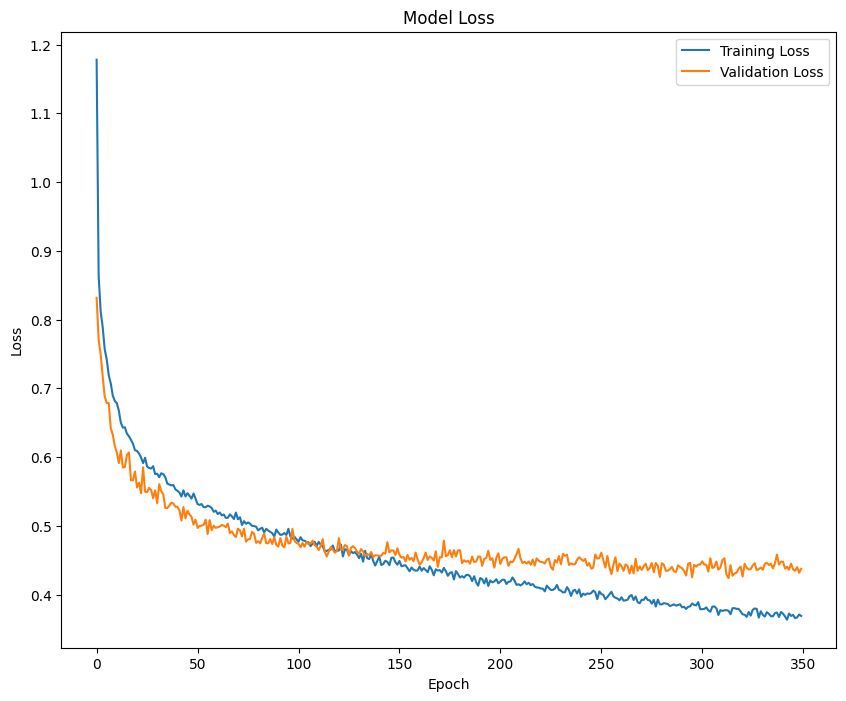

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Load dataset
data = pd.read_csv('Phones_gyroscope_input.csv')  # Make sure to use the correct path

# Extract features and target
X = data[['x', 'y', 'z']].values
y = data['Target']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=seed, stratify=y_encoded)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the MLP model
def build_mlp_model(input_dim, num_classes):
    model = Sequential([
        Dense(1024, input_dim=input_dim, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train MLP model
num_classes = len(label_encoder.classes_)
mlp_model = build_mlp_model(X_train.shape[1], num_classes)
history = mlp_model.fit(X_train, tf.keras.utils.to_categorical(y_train, num_classes),
                        epochs=350, batch_size=64, verbose=1, validation_split=0.1)

# Feature extraction with MLP
intermediate_layer_model = tf.keras.Model(inputs=mlp_model.input, outputs=mlp_model.layers[-2].output)
X_train_features = intermediate_layer_model.predict(X_train)
X_test_features = intermediate_layer_model.predict(X_test)

# Train base models
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=seed,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_features, y_train)

rf_model = RandomForestClassifier(n_estimators=300, random_state=seed)
rf_model.fit(X_train_features, y_train)

# Prepare inputs for the meta-model
xgb_train_preds = xgb_model.predict_proba(X_train_features)
rf_train_preds = rf_model.predict_proba(X_train_features)
meta_train_features = np.hstack((xgb_train_preds, rf_train_preds))

# Logistic Regression Meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=seed)
meta_model.fit(meta_train_features, y_train)

# Test set predictions
xgb_test_preds = xgb_model.predict_proba(X_test_features)
rf_test_preds = rf_model.predict_proba(X_test_features)
meta_test_features = np.hstack((xgb_test_preds, rf_test_preds))
y_pred = meta_model.predict(meta_test_features)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
